# Data Analysis of similarities of cities between New York and Toronto

## 1. Importing Data sets

**(1) Import libraries**

In [1]:
import numpy as np
import pandas as pd
import requests
import random
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize
import folium
from folium.plugins import MiniMap
from geopy.geocoders import Nominatim
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn import metrics
from PIL import Image
import matplotlib.patches as mpatches
from wordcloud import WordCloud, get_single_color_func

print('Libraries imported.')

Libraries imported.


**(2) Load neighborhoods in New York and Toronto from:**

New York: https://cocl.us/new_york_dataset

Toronto: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

**(i) Download and load data from New York (US)**

In [2]:
# Download and load New York data
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')
print('Loading data...')
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
print('\n...data loaded succesfully!')

Data downloaded!
Loading data...

...data loaded succesfully!


**(ii) Download and load data from Toronto (Canada)**

In [3]:
webPage = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")

print('Data downloaded!')
print('Loading data...')

html = webPage.text                                                                       
tableInit = html.find('<table class="wikitable sortable">')                            
tableFinal = html.find('</table>')                                                      
htmlTable = html[tableInit:tableFinal]

print('\n...data loaded succesfully!')

Data downloaded!
Loading data...

...data loaded succesfully!


## 2. Data Wrangling

**(1) Wrangle the data from New York**

In [4]:
neighborhoods_ny = pd.DataFrame(columns = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'])

for data in newyork_data['features']:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods_ny = neighborhoods_ny.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

#Take only neighborhoods from Manhattan:
neighborhoods_ny = neighborhoods_ny[neighborhoods_ny['Borough'] == 'Manhattan'].reset_index(drop=True)

print('Number of neighborhoods found in the city of New York: ', neighborhoods_ny.shape[0])
neighborhoods_ny.head()

Number of neighborhoods found in the city of New York:  40


,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


**(2) Wrangle the data from Toronto**

In [5]:
table = pd.read_html(htmlTable, header = 0)[0]                                            
table["Borough"] = table["Borough"].replace({"Not assigned":np.nan})                
table.dropna(inplace = True)                                                          
table.where(table != "Not assigned", table["Borough"], axis = 0, inplace = True)  
table.rename(columns={"Neighbourhood": "Neighborhood"}, inplace = True)
table.head()

joinedRows = table.groupby("Postal Code")["Neighborhood"].apply(lambda x: ", ".join(x)) 
table.drop_duplicates(["Postal Code"],inplace = True)        

df = table.join(joinedRows, on = "Postal Code", lsuffix='_single')                       
df.drop(columns = ["Neighborhood_single"], inplace = True)                         
df.reset_index(drop = True, inplace = True)

In [6]:
# Add latitude and longitude from: http://cocl.us/Geospatial_data
!wget -q -O 'Geospatial_Coordinates.csv' http://cocl.us/Geospatial_data

geo = pd.read_csv("Geospatial_Coordinates.csv", index_col = 0)         
neighborhoods_to = df.join(geo, on = "Postal Code")

#Take only those neighborhoods that contain the word Toronto
neighborhoods_to = neighborhoods_to[neighborhoods_to['Borough'].str.contains('Toronto')].reset_index(drop=True)
neighborhoods_to.drop("Postal Code", axis = 1, inplace = True)
print('Number of neighborhoods found in the city of Toronto: ', neighborhoods_to.shape[0])

neighborhoods_to.head()

Number of neighborhoods found in the city of Toronto:  39


,Borough,Neighborhood,Latitude,Longitude
0,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,Downtown Toronto,St. James Town,43.651494,-79.375418
4,East Toronto,The Beaches,43.676357,-79.293031


**(3) Join NY and Toronto tables**

In [7]:
df = neighborhoods_ny.append(neighborhoods_to, True).reset_index(drop = True)
pd.set_option('max_rows', 6)
df

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
...,...,...,...,...
76,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280
77,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
78,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558


## 3. Exploratory Data Analysis (EDA)

**(1) Visualize the neighborhoods in New York and Toronto**

**(i) Get center coordinates to visualize both cities**

In [8]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="http")
location = geolocator.geocode(address)
ny_latitude = location.latitude
ny_longitude = location.longitude
print('The geograpical coordinate of New York City (Manhattan) are {}, {}.'.format(ny_latitude, ny_longitude))

address = 'Toronto'

location = geolocator.geocode(address)
to_latitude = location.latitude
to_longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(to_latitude, to_longitude))

centerLatitude = (ny_latitude + to_latitude)/2
centerLongitude = (ny_longitude + to_longitude)/2

print('\nThe geograpical central coordinates are {}, {}.'.format(centerLatitude, centerLongitude))

The geograpical coordinate of New York City (Manhattan) are 40.7896239, -73.9598939.
The geograpical coordinate of Toronto are 43.6534817, -79.3839347.

The geograpical central coordinates are 42.2215528, -76.6719143.


**(ii) Visualize both neighborhoods using folium**

In [9]:
map_tony = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=7, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)
map_tony

**(2) Visualize the neighborhoods in New York**

In [10]:
map_tony = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)

minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)
map_tony

**(3) Visualize the neighborhoods in Toronto**

In [11]:
map_tony = folium.Map(location=[to_latitude, to_longitude], zoom_start=11, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)

minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)
map_tony

## 4. Modeling

**(1) Extraction of features**

Use nearby venues of each neighborhood as its features by employing Foursquare REST API to get the venues based on the latitude and longitude

**(i) Set up an authentication**

In [12]:
CLIENT_ID = 'O4PEMC4ARWL5RGCD1NUTQXJFG2HZNWYV4WPYKBZA5VXH1HYW' # your Foursquare ID
CLIENT_SECRET = 'PK5TCYAOUZB3XYJWQ5G4KZSTOAKIB5V1VGABJZ0QCHTKYHEB' # your Foursquare Secret
VERSION = '20200709'
LIMIT = 100

**(ii) Send requests, get and process json files**

In [13]:
def getNearbyVenues(names, boroughs, latitudes, longitudes, radius=500):
    ind = 1
    venues_list=[]
    for name, borough, lat, lng in zip(names, boroughs, latitudes, longitudes):
        tmp=[]
        #print(str(ind)+" | "+name)
        ind += 1
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #tmp.append([(j['venue']['name']) for j in results])
        #for item in tmp[0]:
        #    print("\t",item)
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            borough,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Borough',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print("\nDone!")
    return(nearby_venues)   

In [14]:
tony_venues = getNearbyVenues(names=df['Neighborhood'],
                                   boroughs = df['Borough'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )
tony_venues


Done!


,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,Manhattan,40.876551,-73.910660,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,Manhattan,40.876551,-73.910660,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,Manhattan,40.876551,-73.910660,Tibbett Diner,40.880404,-73.908937,Diner
...,...,...,...,...,...,...,...,...
4835,"Business reply mail Processing Centre, South C...",East Toronto,43.662744,-79.321558,The Ten Spot,43.664815,-79.324213,Spa
4836,"Business reply mail Processing Centre, South C...",East Toronto,43.662744,-79.321558,TTC Stop #03049,43.664470,-79.325145,Light Rail Station
4837,"Business reply mail Processing Centre, South C...",East Toronto,43.662744,-79.321558,ONE Academy,43.662253,-79.326911,Gym / Fitness Center


**(iii) One hot encoding and grouping by neighborhoods**

In [15]:
# one hot encoding to change categorical values into numerical values
tony_onehot = pd.get_dummies(tony_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tony_onehot['Neighborhood'] = tony_venues['Neighborhood'] 
tony_onehot['Borough'] = tony_venues['Borough']
tony_onehot['Neighborhood Latitude'] = tony_venues['Neighborhood Latitude']
tony_onehot['Neighborhood Longitude'] = tony_venues['Neighborhood Longitude']

# move neighborhood column to the first column
fixed_columns = [tony_onehot.columns[-1]] + list(tony_onehot.columns[:-1])
tony_onehot = tony_onehot[fixed_columns]

# use groupby and mean of nearby venues to combine
tony_grouped = tony_onehot.groupby(['Neighborhood','Borough','Neighborhood Latitude','Neighborhood Longitude']).mean().reset_index()
tony_grouped

,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Battery Park City,Manhattan,40.711932,-74.016869,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.000000,0.013699,0.0,0.000000,0.0
1,Berczy Park,Downtown Toronto,43.644771,-79.373306,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
2,"Brockton, Parkdale Village, Exhibition Place",West Toronto,43.636847,-79.428191,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,Washington Heights,Manhattan,40.851903,-73.936900,0.011111,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.011111,0.022222,0.0,0.011111,0.0
77,West Village,Manhattan,40.734434,-74.006180,0.010000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.040000,0.000000,0.0,0.000000,0.0
78,Yorkville,Manhattan,40.775930,-73.947118,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.01,0.02,0.0,0.0,0.0,0.010000,0.030000,0.0,0.000000,0.0


**(2) K-means clustering**

**(i) Find the best K using the elbow method**

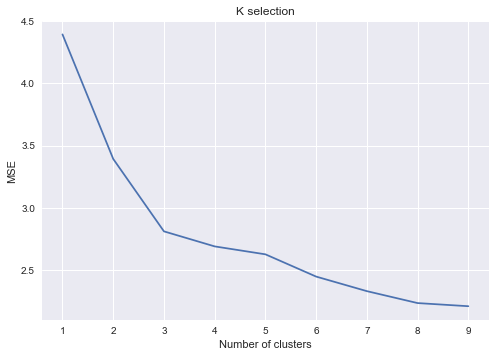

In [51]:
# Finding best k
plt.style.use("seaborn")
Ks = 10
mse = np.zeros((Ks-1))
tony_grouped_clustering = tony_grouped.drop(['Neighborhood','Borough','Neighborhood Latitude','Neighborhood Longitude'], 1)
for n in range(1,Ks):
    
    # set number of clusters
    kclusters = n
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(tony_grouped_clustering)
    mse[n-1] = kmeans.inertia_

plt.plot(range(1,Ks),mse)
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()

According to the elbow method, the best K is 5

**(ii) Model fitting**

In [56]:
# set number of clusters
kclusters = 5
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(tony_grouped_clustering)
    
tony_merged = df

# add clustering labels
tony_merged['Cluster Labels'] = kmeans.labels_

tony_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,Manhattan,Marble Hill,40.876551,-73.910660,1
1,Manhattan,Chinatown,40.715618,-73.994279,2
2,Manhattan,Washington Heights,40.851903,-73.936900,2
...,...,...,...,...,...
76,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,4
77,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,1
78,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,2


## 5. Evaluation & Result

**(1) Analysis of clusters**

Cluster 1

In [57]:
cl1 = tony_merged.loc[tony_merged['Cluster Labels'] == 0, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl1

,Neighborhood
23,Soho
34,Sutton Place
45,Berczy Park
55,"India Bazaar, The Beaches West"


Cluster 2

In [58]:
cl2 = tony_merged.loc[tony_merged['Cluster Labels'] == 1, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl2

,Neighborhood
0,Marble Hill
3,Inwood
7,East Harlem
...,...
70,"Kensington Market, Chinatown, Grange Park"
74,Stn A PO Boxes
77,Church and Wellesley


Cluster 3

In [59]:
cl3 = tony_merged.loc[tony_merged['Cluster Labels'] == 2, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl3

,Neighborhood
1,Chinatown
2,Washington Heights
4,Hamilton Heights
...,...
73,Rosedale
75,"St. James Town, Cabbagetown"
78,"Business reply mail Processing Centre, South C..."


Cluster 4

In [60]:
cl4 = tony_merged.loc[tony_merged['Cluster Labels'] == 3, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl4

,Neighborhood
56,"Commerce Court, Victoria Hotel"


Cluster 5

In [61]:
cl5 = tony_merged.loc[tony_merged['Cluster Labels'] == 4, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl5

,Neighborhood
18,Greenwich Village
27,Gramercy
29,Financial District
...,...
41,"Queen's Park, Ontario Provincial Government"
71,"Summerhill West, Rathnelly, South Hill, Forest..."
76,"First Canadian Place, Underground city"


**(2) Data visualization**

**(i) Display clusters on map using folium**

In [62]:
# create map
map_clusters = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=7, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [63]:
# create map of New York City
map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)
map_clusters

In [64]:
# create map for Toronto
map_clusters = folium.Map(location=[to_latitude, to_longitude], zoom_start=11, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)
map_clusters

**(ii)  Waffle Chart**

In [120]:
def create_waffle_chart(categories, values, height, width, colormap, value_sign=''):

    # compute the proportion of each category with respect to the total
    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]

    # compute the total number of tiles
    total_num_tiles = width * height # total number of tiles
    print ('Total number of tiles is', total_num_tiles)
    
    # compute the number of tiles for each catagory
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

    # print out number of tiles per category
    for i, tiles in enumerate(tiles_per_category):
        print (categories[i] + ': ' + str(tiles))
    
    # initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))

    # define indices to loop through waffle chart
    category_index = 0
    tile_index = 0

    # populate the waffle chart
    for col in range(width):
        for row in range(height):
            tile_index += 1

            # if the number of tiles populated for the current category 
            # is equal to its corresponding allocated tiles...
            if tile_index > sum(tiles_per_category[0:category_index]):
                # ...proceed to the next category
                category_index += 1       
            
            # set the class value to an integer, which increases with class
            waffle_chart[row, col] = category_index
    
    # instantiate a new figure object
    fig = plt.figure()

    # use matshow to display the waffle chart
    plt.matshow(waffle_chart, cmap=colormap)
    plt.colorbar()

    # get the axis
    ax = plt.gca()

    # set minor ticks
    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # add dridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.xticks([])
    plt.yticks([])

    # compute cumulative sum of individual categories to match color schemes between chart and legend
    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]
    #print(values_cumsum)

    # create legend
    legend_handles = []
    for i, category in enumerate(categories):
        if value_sign == '%':
            label_str = category + ' (' + str(values[i]) + value_sign + ')'
        else:
            label_str = category + ' (' + value_sign + str(values[i]) + ')'
            
        #color_val = colormap((float(values_cumsum[i])/total_values))
        color_val = colormap(np.linspace(0,1,5)[i])
        #print(np.arange(1,6)[i]/5)
        legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

    # add legend to chart
    plt.legend(
        handles=legend_handles,
        loc='lower center', 
        ncol=len(categories),
        bbox_to_anchor=(0., -0.2, 0.95, .1)
    )

Total number of tiles is 1200
Cluster I: 623
Cluster II: 395
Cluster III: 106
Cluster IV: 61
Cluster V: 15


<Figure size 576x396 with 0 Axes>

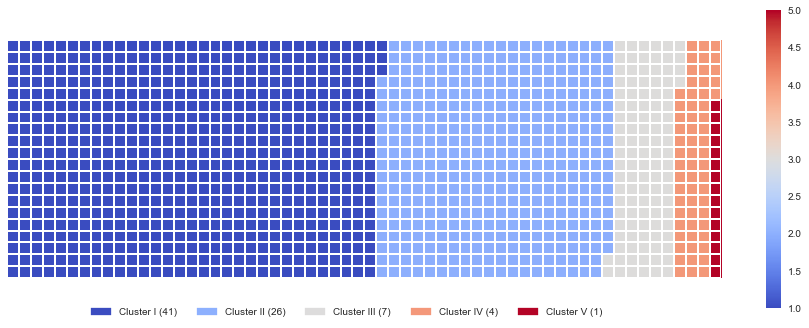

In [121]:
# categories
categories = ['Cluster I', 'Cluster II', 'Cluster III', 'Cluster IV','Cluster V']
# correponding values of categories
values = [cl3.shape[0], cl2.shape[0], cl5.shape[0], cl1.shape[0], cl4.shape[0]]
width = 60 # width of chart
height = 20 # height of chart
colormap = plt.cm.coolwarm # color map class
create_waffle_chart(categories, values, height, width, colormap)

**(iii) Word Cloud**

In [67]:
word_string = ""
for neighborhood in tony_merged["Neighborhood"]:
    elements = ""
    for element in neighborhood.split(","):
        elements += element.strip().replace(" ", "") + " "
    word_string += elements+" "
word_string = word_string.replace(".","")

tmp = cl1["Neighborhood"].tolist()
cl1_list = []
for element in tmp:
    cl1_list.extend(element.split(", "))
cl1_list = [element.replace(" ","") for element in cl1_list]
cl1_list = [element.replace(".","") for element in cl1_list]

tmp = cl2["Neighborhood"].tolist()
cl2_list = []
for element in tmp:
    cl2_list.extend(element.split(", "))
cl2_list = [element.replace(" ","") for element in cl2_list]
cl2_list = [element.replace(".","") for element in cl2_list]
    
tmp = cl3["Neighborhood"].tolist()
cl3_list = []
for element in tmp:
    cl3_list.extend(element.split(", "))
cl3_list = [element.replace(" ","") for element in cl3_list]
cl3_list = [element.replace(".","") for element in cl3_list]

tmp = cl4["Neighborhood"].tolist()
cl4_list = []
for element in tmp:
    cl4_list.extend(element.split(", "))
cl4_list = [element.replace(" ","") for element in cl4_list]    
cl4_list = [element.replace(".","") for element in cl4_list]

tmp = cl5["Neighborhood"].tolist()
cl5_list = []
for element in tmp:
    cl5_list.extend(element.split(", "))
cl5_list = [element.replace(" ","") for element in cl5_list]
cl5_list = [element.replace(".","") for element in cl5_list]

In [33]:
class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

Word cloud created!


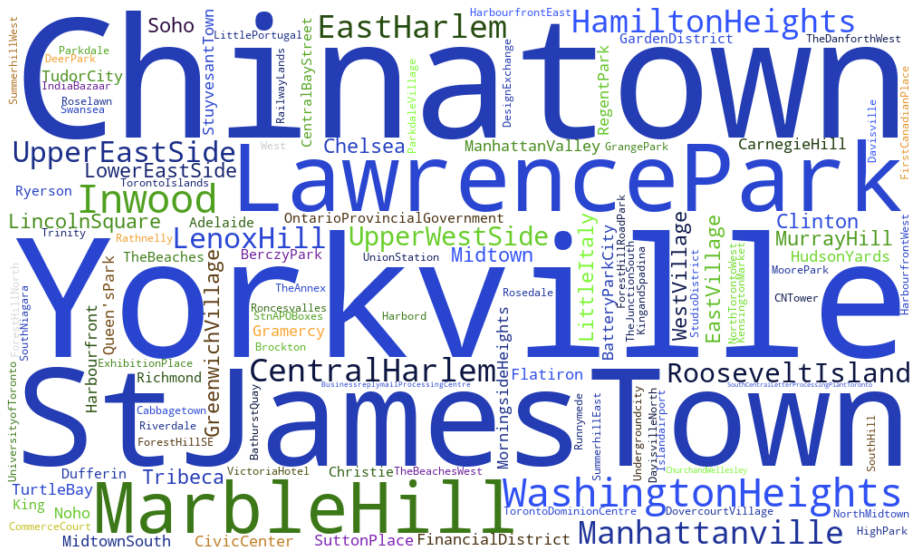

In [68]:
wordcloud = WordCloud(width=1000, height=600, background_color='white', max_words = 500).generate(word_string)

color_to_words = {
    # words below will be colored with a green single color function
    '#3355FF': cl3_list, # blue
    '#FFFC33': cl4_list, # yellow
    '#80FF33': cl2_list, # green
    '#FFA833': cl5_list, # orange
    '#B533FF': cl1_list # purple
}

default_color = 'grey'

print('Word cloud created!')

fig = plt.figure()
fig.set_figwidth(500)
fig.set_figheight(10)

grouped_color_func = GroupedColorFunc(color_to_words, default_color)

# Apply our color function
wordcloud.recolor(color_func=grouped_color_func)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

e.g. Yorkville(New York), Manhattanville(New York), Chinatown(Toronto), St. James Town(Toronto), and so on are similar

**(iv) Bar chart for the insight of the clusters**

The bar chart shows the features with higher frequency in the centroids

In [123]:
# copy kmeans.cluster_centers_
tmp = np.zeros((kmeans.cluster_centers_.shape))
# values = [cl3.shape[0], cl2.shape[0], cl5.shape[0], cl1.shape[0], cl4.shape[0]]
tmp[0,:] = kmeans.cluster_centers_[2,:]
tmp[1,:] = kmeans.cluster_centers_[1,:]
tmp[2,:] = kmeans.cluster_centers_[4,:]
tmp[3,:] = kmeans.cluster_centers_[0,:]
tmp[4,:] = kmeans.cluster_centers_[3,:]

# pick the most frequent categories 
maxidx = []
for i in range(5):
    maxidx.extend(tmp[i,:].argsort()[-7:][::-1])
    
args = np.asarray(list(set(maxidx)))
table = pd.DataFrame(data = tmp[:,args.astype(int)], index = ['Cluster I', 'Cluster II', 'Cluster III', 'Cluster IV','Cluster V'], columns = tony_grouped_clustering.columns[args.astype(int)])
table = table.transpose()
table.drop(['Doner Restaurant','Drugstore','Dry Cleaner'], inplace = True)

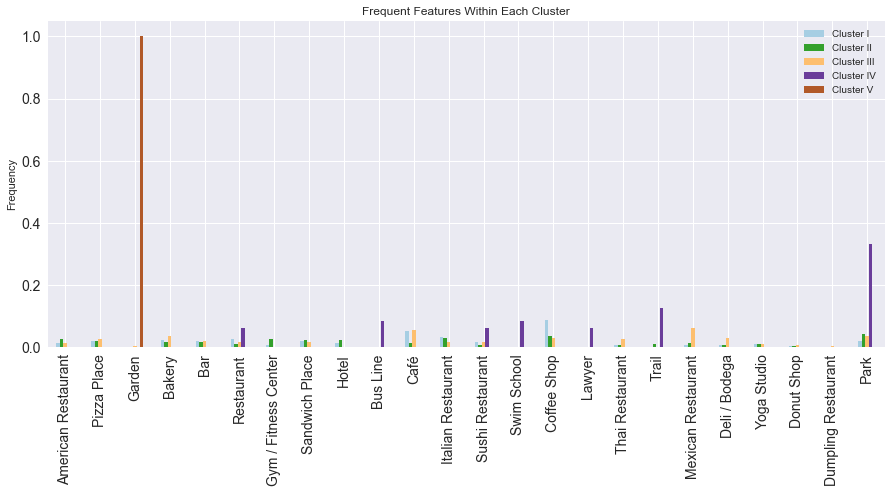

In [124]:
plt.style.use('seaborn')
ax = table.plot(kind='bar', figsize=(15,6), rot=90, fontsize = 14, colormap = 'Paired')
bars = ax.get_children()
plt.title("Frequent Features Within Each Cluster")
plt.ylabel("Frequency")
plt.show()

Cluster V is not meaningful. So except this cluster, re-plot the bar chart

In [86]:
maxidx = []
for i in range(4):
    maxidx.extend(tmp[i,:].argsort()[-6:][::-1])
    
args = np.asarray(list(set(maxidx)))
table = pd.DataFrame(data = tmp[0:4,args.astype(int)], index = ['Cluster I', 'Cluster II', 'Cluster III', 'Cluster IV'], columns = tony_grouped_clustering.columns[args.astype(int)])
table = table.T
#table.drop(['Drugstore','Dry Cleaner'], inplace = True)

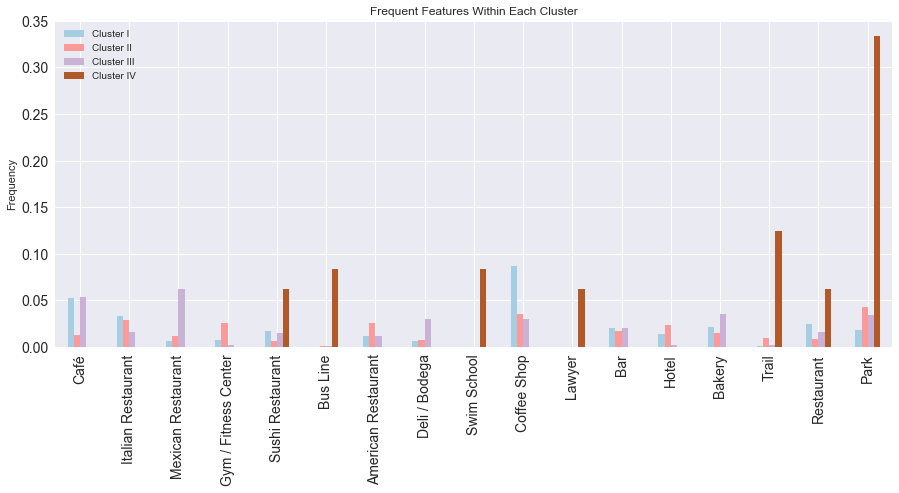

In [87]:
plt.style.use('seaborn')
ax = table.plot(kind='bar', figsize=(15,6), rot=90, fontsize = 14, colormap = "Paired")
bars = ax.get_children()
plt.title("Frequent Features Within Each Cluster")
plt.ylabel("Frequency")
plt.show()

Cluster I with coffee shop, cafe, restaurant, and bar<br>
Cluster II with hotel, gym/fitness center, and american/italian restaunrant<br>
Cluster III with mexican restaurant, bodega, and bakery<br>
Cluster IV with bus line, swim school, trail, and park

**(3) Result**

**(i) Description of Clusters**
<ul>
    <li>Cluster I with coffee shop, cafe, restaurant, and bar</li>
    <li>Cluster II with hotel, gym/fitness center, and american/italian restaurant</li>
    <li>Cluster III with mexican restaurant, bodega, and bakery</li>
    <li>Cluster IV with bus line, swim school, trail, and park</li>
</ul>

**(ii) Conclusion<br>**
Anyone who wants to move from Manhattan, US to Toronto, CA or vice versa can utilize the above results of the anlayses to find the best place where is similar to one's previous environment.<br>
<ul>
    <li>The maps displaying the clusters by different colors can offer the useful geographical information</li>
    <li>The word cloud gives the intuition to find and recognize the similar place easily</li>
    <li>The description of clusters offers the characteristic of neighbourhood where one has lived, and one will move in</li>
</ul>